# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [153]:
feat_info.info

<bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric

In [6]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.missing_or_unknown.value_counts()


[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,XX]      1
[-1,X]       1
[XX]         1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [8]:
feat_info['missing_or_unknown']

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [9]:
convertToInt = lambda x : x if (not(bool(x)) or x.isalpha()) else int(x)
convertToList = lambda x: list(map(convertToInt, x.strip("[]").split(',')))
feat_info['missing_or_unknown']=feat_info['missing_or_unknown'].apply(convertToList)
feat_info['missing_or_unknown'][0]


for column in azdias.columns:
    missing_list = feat_info[feat_info['attribute']==column]['missing_or_unknown'].values[0]
    
    azdias[column].replace(missing_list, np.nan, inplace=True)

In [10]:
azdias.head(50)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [14]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [11]:
cameo_int = azdias['CAMEO_INTL_2015'].unique()
cameo_int

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

total_nan = (azdias.isnull().sum(axis = 0) / len(azdias)) * 100
total_nan

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

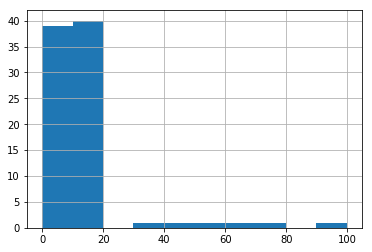

In [7]:
# Investigate patterns in the amount of missing data in each column.
total_nan.hist()


(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

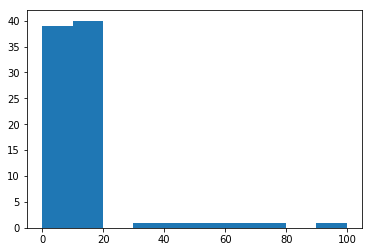

In [17]:
#add columns
plt.hist(total_nan)

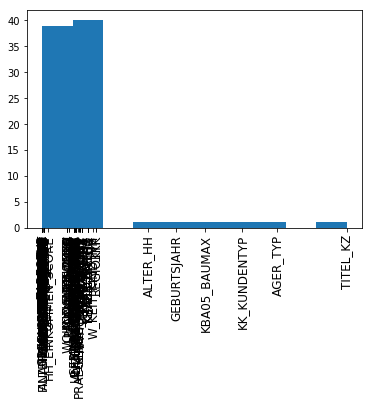

In [17]:
#add columns re-try
plt.hist(total_nan)
plt.xticks(total_nan, total_nan.index, rotation = 90, fontsize = 12)
plt.show()

In [13]:
#display the jumbled columns for analysis
total_nan_normal = total_nan[total_nan < 30]
total_nan_normal

ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL           

In [14]:
#see how many columns are not missing data
total_nan_zero = total_nan[total_nan == 0]
total_nan_zero

ANREDE_KZ                0.0
FINANZ_MINIMALIST        0.0
FINANZ_SPARER            0.0
FINANZ_VORSORGER         0.0
FINANZ_ANLEGER           0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_HAUSBAUER         0.0
FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
SEMIO_SOZ                0.0
SEMIO_FAM                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
dtype: float64

In [15]:
#confirm outliers
total_nan_outliers = total_nan[total_nan >= 30]
total_nan_outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [16]:
#saving a copy of azdias just in case
azdias_backup = azdias.copy()


In [17]:
azdias_backup.shape

(891221, 85)

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#defining what columns after error trying to use calc
out_columns = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']


azdias.drop(out_columns, axis = 1, inplace = True)
azdias.shape

(891221, 79)

### Discussion 1.1.2: Assess Missing Data in Each Column


**Observations:**

Out of the 85 columns in azdias.csv, 79 of them had less <= 20% missing data. These columns have two clusters: 0-10% and 10 - 20%. The remaining 6 columns are outliers.

24 columns are not missing any data. 

**Outliers:**

The following six columns were removed due to having >= 30% missin data: 

'AGER_TYP'  
'GEBURTSJAHR'  
'TITEL_KZ'  
'ALTER_HH'  
'KK_KUNDENTYP'  
'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
#azdias is still good, but backing up again.
azdias_backup = azdias.copy()


In [20]:
# How much data is missing in each row of the dataset?
missing_data = azdias.isnull().sum(axis = 1)
missing_data.head(20)


0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
dtype: int64

In [21]:
missing_data.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

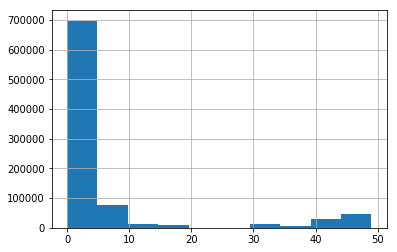

In [16]:
missing_data.hist()

***Observation:***  
Mean missing columns < 6   
Histogram shows the biggest group is <= 10

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#split on count
threshhold = 10

#main df = azdias
#list of miss by row = missing_data

#less missing < 10
less_missing = missing_data[missing_data < threshhold]
#more missing = >= 10
more_missing = missing_data[missing_data >= threshhold]

#test
more_missing

0         43
11        47
14        47
17        47
20        10
24        47
26        19
30        34
35        43
46        40
48        47
53        43
54        47
61        43
62        43
69        47
75        47
76        43
81        45
83        43
90        34
97        47
99        47
103       47
106       43
108       47
109       43
112       47
133       47
137       47
          ..
891049    47
891055    33
891061    43
891062    19
891063    43
891064    47
891069    15
891072    47
891074    34
891092    47
891095    47
891100    34
891117    19
891119    17
891120    17
891130    34
891137    34
891140    34
891154    11
891159    43
891164    43
891169    18
891170    19
891171    34
891172    16
891173    19
891175    47
891185    47
891187    47
891203    14
Length: 116478, dtype: int64

In [23]:
#get index Less_missing
less_index = list(less_missing.index)
#get index more_missing
more_index = list(more_missing.index)

In [24]:
#test
less_index

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 15,
 16,
 18,
 19,
 21,
 22,
 23,
 25,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 49,
 50,
 51,
 52,
 55,
 56,
 57,
 58,
 59,
 60,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 100,
 101,
 102,
 104,
 105,
 107,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 134,
 135,
 136,
 139,
 140,
 141,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 164,
 166,
 167,
 169,
 170,
 171,
 172,
 174,
 177,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 204,
 206,
 207,
 208,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 231,
 232,
 234,
 235,


In [25]:
#main df = azdias backup
azdias_backup = azdias.copy

#df for < 10 using indexes
azdias_less = azdias.iloc[less_index, :]

#df for > 10 using indexes
azdias_more = azdias.iloc[more_index, :]

In [26]:
azdias.shape

(891221, 79)

In [27]:
azdias_less.shape

(774743, 79)

In [28]:
azdias_more.shape

(116478, 79)

In [36]:
calc = 774743 + 116478
calc

891221

In [9]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution(column):
    fig, axes = plt.subplots(1, 2)
    fig.suptitle(column)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    count_less = azdias_less[column].value_counts()
    count_more = azdias_more[column].value_counts()
    sns.barplot(x = count_less.index, y = count_less.values / len(azdias_less[column]), ax = axes[0])
    sns.barplot(x = count_more.index, y = count_more.values / len(azdias_more[column]), ax = axes[1])
    axes[0].set_title('Subset with Less Missing Data')
    axes[1].set_title('Subset with More Missing Data')
    



In [10]:
#find  five columns
column_5 = azdias_less.iloc[0, 5]

In [22]:
column_5

2

In [10]:
column_list = ['FINANZ_MINIMALIST','ANREDE_KZ','CJT_GESAMTTYP','ALTERSKATEGORIE_GROB','FINANZ_SPARER']

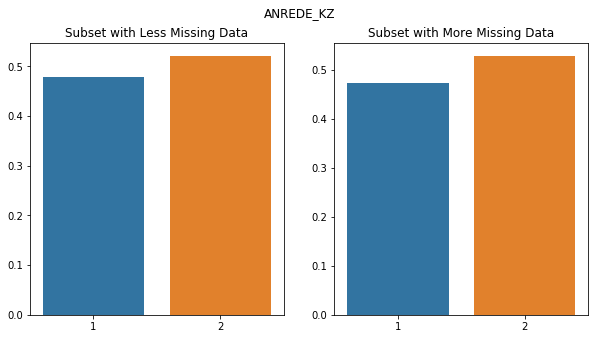

In [12]:
compare_distribution('ANREDE_KZ')

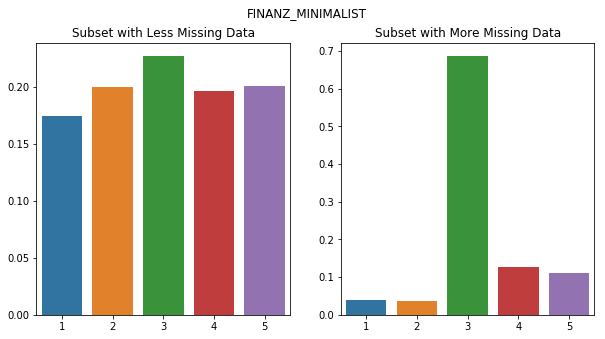

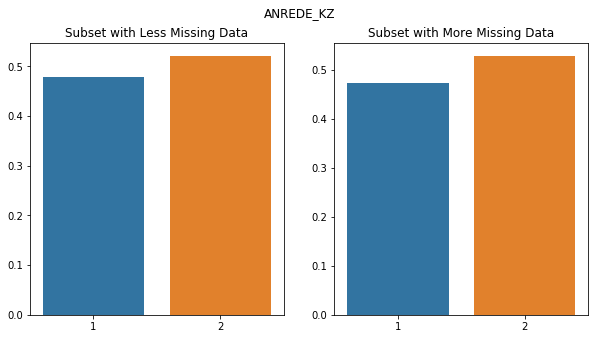

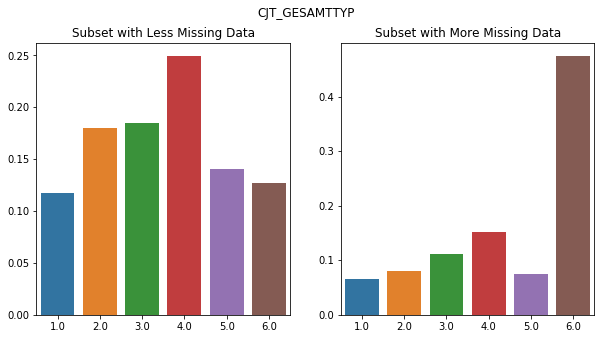

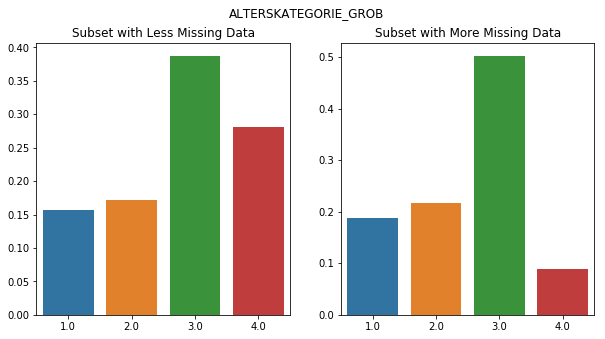

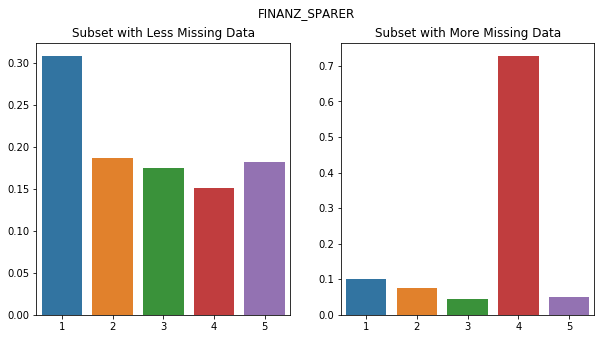

In [25]:
for i in column_list:
    compare_distribution(i)

### Discussion 1.1.3: Assess Missing Data in Each Row

Two dataframes were created: azdias_less which has data missing for < 10 values per row and azdias_more which has data missing >=10 values per row. 

I ran comparisons for these five columns:   
'FINANZ_MINIMALIST'  
'ANREDE_KZ'  
'CJT_GESAMTTYP'  
'ALTERSKATEGORIE_GROB'    
'FINANZ_SPARER'


**Observations:**  
Column 'ANREDE_KZ' has the same, or close to it, distribution between the two datasets. The other columns have varying distribution in the different datasets. 



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [44]:
# How many features are there of each data type?
feat_info


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [29]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

### Count of Categorical and Mixed types:
categorical    21  
mixed           7

I have too many?! should be 79 total. Going back.

In [30]:
#get the column names for the two types to research
categorical_columns = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
mixed_columns = feat_info[feat_info['type'] == 'mixed'].attribute.tolist()

In [31]:
#test
len(categorical_columns)

21

In [28]:
categorical_columns

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [32]:
azdias_less.shape

(774743, 79)

In [33]:
# see help email
# need to get only the columns that are in my data set, getting errors because they aren't there.
categorical_columns = set(list(azdias_less.columns)).intersection(list(categorical_columns))

In [30]:
categorical_columns

{'ANREDE_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP'}

In [79]:
#test
len(mixed_columns)

7

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#cat_columns2

#step 1.2.1 - ask mentor about keyerror

binary = []
multi = []
for i in list(categorical_columns):
    if (azdias_less[i].value_counts().count()==2):
        
        binary.append(i)
    else:
        multi.append(i)

In [35]:
azdias_less[binary].head()

,OST_WEST_KZ,VERS_TYP,GREEN_AVANTGARDE,SOHO_KZ,ANREDE_KZ
1,W,2.0,0,1.0,2
2,W,1.0,1,0.0,2
3,W,1.0,0,0.0,2
4,W,2.0,0,0.0,1
5,W,2.0,0,0.0,2


*** Observation:***
Column OST_WEST_KZ is alpha. 

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_less['OST_WEST_KZ'] = azdias_less['OST_WEST_KZ'].replace(['W','O'], ['0','1'])
azdias_less[binary].head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,OST_WEST_KZ,VERS_TYP,GREEN_AVANTGARDE,SOHO_KZ,ANREDE_KZ
1,0,2.0,0,1.0,2
2,0,1.0,1,0.0,2
3,0,1.0,0,0.0,2
4,0,2.0,0,0.0,1
5,0,2.0,0,0.0,2


In [37]:
multi

['LP_FAMILIE_GROB',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'GFK_URLAUBERTYP',
 'NATIONALITAET_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_STATUS_GROB',
 'ZABEOTYP',
 'LP_STATUS_FEIN',
 'SHOPPER_TYP',
 'GEBAEUDETYP']

In [38]:
# Dropping multi-level columns
azdias_less.drop(multi, axis = 1, inplace = True)
azdias_less.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(774743, 66)

*** NOTE: ****
I accidentally ran the above too many times, hence the error. Checked below

In [39]:
#check after multi-level drop
azdias_less.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774743 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     772147 non-null float64
ANREDE_KZ                774743 non-null int64
FINANZ_MINIMALIST        774743 non-null int64
FINANZ_SPARER            774743 non-null int64
FINANZ_VORSORGER         774743 non-null int64
FINANZ_ANLEGER           774743 non-null int64
FINANZ_UNAUFFAELLIGER    774743 non-null int64
FINANZ_HAUSBAUER         774743 non-null int64
GREEN_AVANTGARDE         774743 non-null int64
HEALTH_TYP               741323 non-null float64
LP_LEBENSPHASE_FEIN      732988 non-null float64
LP_LEBENSPHASE_GROB      735655 non-null float64
PRAEGENDE_JUGENDJAHRE    749241 non-null float64
RETOURTYP_BK_S           774743 non-null float64
SEMIO_SOZ                774743 non-null int64
SEMIO_FAM                774743 non-null int64
SEMIO_REL                774743 non-null int64
SEMIO_MAT                774743 non-null int64
SEMIO_VERT               774743

#### Discussion 1.2.1: Re-Encode Categorical Features

*** Actions Binary:***
I was able to narrow down the binary categorical columns to a list of 5, these five were examined to show that only one of them, OST_WEST_KZ, was binary. The alpha characters 'W' and 'O' were present. These were replaced with values 0 and 1 respectively.

*** Actions Multi-level***

All identified multi-level columns were dropped. 

['LP_STATUS_FEIN',
 'CJT_GESAMTTYP',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'LP_STATUS_GROB',
 'SHOPPER_TYP',
 'GEBAEUDETYP',
 'ZABEOTYP',
 'GFK_URLAUBERTYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'NATIONALITAET_KZ',
 'LP_FAMILIE_FEIN']


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
#looking at all mixed
mixed_columns = feat_info[feat_info['type'] == 'mixed']
mixed_columns

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_less['PRAEGENDE_JUGENDJAHRE'].unique()


array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

##### PRAEGENDE_JUGENDJAHRE  
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)  

-1: unknown  
0: unknown  
1: 40s - war years (Mainstream, E+W)  
2: 40s - reconstruction years (Avantgarde, E+W)  
3: 50s - economic miracle (Mainstream, E+W)  
4: 50s - milk bar / Individualisation (Avantgarde, E+W)  
5: 60s - economic miracle (Mainstream, E+W)  
6: 60s - generation 68 / student protestors (Avantgarde, W)  
7: 60s - opponents to the building of the Wall (Avantgarde, E)  
8: 70s - family orientation (Mainstream, E+W)  
9: 70s - peace movement (Avantgarde, E+W)  
10: 80s - Generation Golf (Mainstream, W)  
11: 80s - ecological awareness (Avantgarde, W)  
12: 80s - FDJ / communist party youth organisation (Mainstream, E)  
13: 80s - Swords into ploughshares (Avantgarde, E)  
14: 90s - digital media kids (Mainstream, E+W)  
15: 90s - ecological awareness (Avantgarde, E+W)  

In [61]:
# 16 unique values
pj_range = np.arange(-1, 16)

# Break out decades
# [np.nan, np.nan, 40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]

# Break out movements : 0 for mainstream and 1 for avant
# [np.nan, np.nan, 0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]

In [42]:
#backup azdias_less
azdias_less_backup = azdias_less.copy()

In [43]:
# creat the new columns with the old data, then replace with the my lists from above - keep formatting
azdias_less['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_less['PRAEGENDE_JUGENDJAHRE']
azdias_less['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] =  azdias_less['PRAEGENDE_JUGENDJAHRE']

#test new colum
azdias_less.info()

    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 774743 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              772147 non-null float64
ANREDE_KZ                         774743 non-null int64
FINANZ_MINIMALIST                 774743 non-null int64
FINANZ_SPARER                     774743 non-null int64
FINANZ_VORSORGER                  774743 non-null int64
FINANZ_ANLEGER                    774743 non-null int64
FINANZ_UNAUFFAELLIGER             774743 non-null int64
FINANZ_HAUSBAUER                  774743 non-null int64
GREEN_AVANTGARDE                  774743 non-null int64
HEALTH_TYP                        741323 non-null float64
LP_LEBENSPHASE_FEIN               732988 non-null float64
LP_LEBENSPHASE_GROB               735655 non-null float64
PRAEGENDE_JUGENDJAHRE             749241 non-null float64
RETOURTYP_BK_S                    774743 non-null float64
SEMIO_SOZ                         774743 non-null int64
SEMIO_FAM                         774

In [44]:
# do the replacements w/ .replace :
#takeout nan
azdias_less['PRAEGENDE_JUGENDJAHRE_DECADE'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], \
                                                    [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90],
                                                    inplace = True)

azdias_less['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], \
                                                     [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1],
                                                     inplace = True)



/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [45]:
azdias_less.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,80.0,0.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,70.0,0.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,80.0,1.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,90.0,1.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,50.0,0.0


In [46]:
#Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_less['CAMEO_INTL_2015'].head()


1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

#### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code  

-1: unknown  
11: Wealthy Households - Pre-Family Couples & Singles  
12: Wealthy Households - Young Couples With Children  
13: Wealthy Households - Families With School Age Children  
14: Wealthy Households - Older Families & Mature Couples  
15: Wealthy Households - Elders In Retirement  
21: Prosperous Households - Pre-Family Couples & Singles  
22: Prosperous Households - Young Couples With Children  
23: Prosperous Households - Families With School Age Children  
24: Prosperous Households - Older Families & Mature Couples  
25: Prosperous Households - Elders In Retirement  
31: Comfortable Households - Pre-Family Couples & Singles  
32: Comfortable Households - Young Couples With Children  
33: Comfortable Households - Families With School Age Children  
34: Comfortable Households - Older Families & Mature Couples  
35: Comfortable Households - Elders In Retirement  
41: Less Affluent Households - Pre-Family Couples & Singles  
42: Less Affluent Households - Young Couples With Children  
43: Less Affluent Households - Families With School Age Children  
44: Less Affluent Households - Older Families & Mature Couples  
45: Less Affluent Households - Elders In Retirement  
51: Poorer Households - Pre-Family Couples & Singles  
52: Poorer Households - Young Couples With Children  
53: Poorer Households - Families With School Age Children  
54: Poorer Households - Older Families & Mature Couples  
55: Poorer Households - Elders In Retirement  
XX: unknown  

In [47]:
#Get the tens spot w/ division and avoid float. Use new column syntax
azdias_less['CAMEO_INTL_2015_WEALTH'] = (pd.to_numeric(azdias_less['CAMEO_INTL_2015']) / 10).round(0)

#Get the ones spot w/ modulo and avoid float. Use new columny syntax
azdias_less['CAMEO_INTL_2015_STAGE'] = (pd.to_numeric(azdias_less['CAMEO_INTL_2015']) % 10).round(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [48]:
#test results w/ head
azdias_less['CAMEO_INTL_2015'].head(3)

1    51
2    24
3    12
Name: CAMEO_INTL_2015, dtype: object

In [49]:
azdias_less.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1.0,2.0


**Results:**

51 broke into 5.0 and 1.0  
24 broke into 2.0 and 4.0  
12 broke into 1.0 and 2.0


In [50]:
mixed_columns

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [51]:
#making list of columns to drop including the ones i'm not re-engineering adn the 2 original that were.
drop_mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX']

In [52]:
#drop columns
for i in drop_mixed:
    azdias_less.drop(i, axis = 1, inplace = True)
    

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [53]:
#error above, executed too many times
azdias_less.shape

(774743, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Two new variables were created for the following two columns.

***PRAEGENDE_JUGENDJAHRE***  
This column contained a 2 digit value corresponding to a decade and a social movement. I created two new variable's with one each for Movement and Decade and then replaced in place to turn the corresponding 2 character into the appropriate  value.

PRAEGENDE_JUGENDJAHRE_DECADE - Replaced the original value with  the corresponding decade  
PRAEGENDE_JUGENDJAHRE_MOVEMENT - 0 or 1 to represent the movement

***CAMEO_INTL_2015***  
This column contained a 2 digit number and needed the 10 position and 1 position broken out on there own.

CAMEO_INTL_2015_WEALTH - I divided by 10 and rounded to 0 to isolate the 10 position representing type of wealth.  
CAMEO_INTL_2015_STAGE - I used modulo by 10 to just keep the 1 position representing the stage of life. 

***Remaining Mixed Columns*** 
The remaining mixed columns found in the dataframe were dropped without further engineering.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#I already dropped the original two mixed columns that were explored.

In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df.copy()
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    
    
    convertToInt = lambda x : x if (not(bool(x)) or x.isalpha()) else int(x)
    convertToList = lambda x: list(map(convertToInt, x.strip("[]").split(',')))
    feat_info['missing_or_unknown']=feat_info['missing_or_unknown'].apply(convertToList)
    feat_info['missing_or_unknown'][0]


    for column in df_clean.columns:
        missing_list = feat_info[feat_info['attribute']==column]['missing_or_unknown'].values[0]
    
        df_clean[column].replace(missing_list, np.nan, inplace=True)
    
    
    
    # remove selected columns and rows, ...
    out_columns = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df_clean.drop(out_columns, axis = 1, inplace = True)
    
    missing_data = df_clean.isnull().sum(axis = 1)
    threshhold = 10
    less_missing=missing_data[missing_data<threshhold]
    less_index=list(less_missing.index)
    df_clean = df_clean.iloc[less_index,:]
    
    categorical_columns =feat_info[feat_info['type']=='categorical']['attribute'].values
    #Categorical columns present in the data with few missing rows
    categorical_columns=set(list(df_clean.columns)).intersection(list(categorical_columns))
    
    multi_columns = []
    for column in list(categorical_columns):
        if (df_clean[column].value_counts().count()>2):
        
            multi_columns.append(column)
            
    #Drop multi level columns
    df_clean.drop(multi_columns, axis=1, inplace=True)  
    
    # select, re-encode, and engineer column values.
    
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace(['W','O'], ['0','1'])
    
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] =  df_clean['PRAEGENDE_JUGENDJAHRE']
    
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], \
                                                    [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90],
                                                    inplace = True)

    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], \
                                                     [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1],
                                                     inplace = True)
  	
    df_clean['CAMEO_INTL_2015_WEALTH'] = (pd.to_numeric(df_clean['CAMEO_INTL_2015']) / 10).round(0)

    #Get the ones spot w/ modulo and avoid float. Use new columny syntax
    df_clean['CAMEO_INTL_2015_STAGE'] = (pd.to_numeric(df_clean['CAMEO_INTL_2015']) % 10).round(0)
    
    #making list of columns to drop including the ones i'm not re-engineering adn the 2 original that were.
    drop_mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX']
    #drop columns
    for i in drop_mixed:
        df_clean.drop(i, axis = 1, inplace = True)

    
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
final_nan = azdias_less.isnull().sum() * 100/len(azdias_less)
final_nan 


ALTERSKATEGORIE_GROB              0.335079
ANREDE_KZ                         0.000000
FINANZ_MINIMALIST                 0.000000
FINANZ_SPARER                     0.000000
FINANZ_VORSORGER                  0.000000
FINANZ_ANLEGER                    0.000000
FINANZ_UNAUFFAELLIGER             0.000000
FINANZ_HAUSBAUER                  0.000000
GREEN_AVANTGARDE                  0.000000
HEALTH_TYP                        4.313689
RETOURTYP_BK_S                    0.000000
SEMIO_SOZ                         0.000000
SEMIO_FAM                         0.000000
SEMIO_REL                         0.000000
SEMIO_MAT                         0.000000
SEMIO_VERT                        0.000000
SEMIO_LUST                        0.000000
SEMIO_ERL                         0.000000
SEMIO_KULT                        0.000000
SEMIO_RAT                         0.000000
SEMIO_KRIT                        0.000000
SEMIO_DOM                         0.000000
SEMIO_KAEM                        0.000000
SEMIO_PFLIC

In [55]:
# do that now.
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
imputer = Imputer(strategy = "most_frequent")

azdias_clean = imputer.fit_transform(azdias_less)



In [57]:
# Apply feature scaling to the general population demographics data.

azdias_fscaled = scaler.fit_transform(azdias_clean)
azdias_fscaled = pd.DataFrame(azdias_fscaled, index = list(azdias_less.index), columns = list(azdias_less.columns))

In [58]:
azdias_fscaled.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
1,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,0.422301,1.435587,0.563825,-0.179238,-0.132956,0.679358,1.106006,-0.531136,1.121604,-1.249876
2,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,-0.953065,0.405294,0.563825,-0.179238,-0.132956,-0.795816,1.106006,1.882757,-0.898035,0.763676
3,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.953065,-0.625000,0.563825,-1.183153,-1.003767,-0.058229,-0.259273,-0.531136,-1.571248,-0.578692
4,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,0.422301,-0.625000,-0.339744,0.824677,0.302450,1.416945,-0.259273,-0.531136,0.448391,0.092492
5,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,0.422301,1.435587,1.467394,-1.183153,-1.003767,-0.058229,-1.624552,-0.531136,1.121604,0.763676
6,-0.783374,0.958422,-1.488785,1.540017,-1.770775,1.468541,0.981043,-0.103075,-0.531136,-0.315096,...,-0.953065,1.435587,1.467394,0.824677,0.302450,-0.058229,0.423366,-0.531136,-0.898035,-0.578692
7,-1.765558,-1.043381,-0.036773,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,-1.637628,...,-0.953065,0.405294,0.563825,-1.183153,-0.132956,-0.795816,-0.259273,-0.531136,-1.571248,0.763676
8,0.198811,-1.043381,0.689233,0.867244,-1.044684,0.789423,-0.454293,-0.818216,1.882757,1.007436,...,0.422301,-0.625000,-0.339744,-1.183153,-0.568361,-0.058229,0.423366,1.882757,-1.571248,0.092492
9,0.198811,0.958422,-0.762779,0.867244,-1.044684,0.110306,1.698711,0.612067,1.882757,-0.315096,...,0.422301,-0.625000,-0.339744,-1.183153,-1.003767,-1.533403,1.106006,1.882757,-0.898035,1.434861
10,0.198811,0.958422,-0.762779,-0.478302,1.133590,0.110306,-1.171961,1.327209,-0.531136,-0.315096,...,-0.953065,-0.625000,-0.339744,0.824677,0.302450,1.416945,-1.624552,-0.531136,1.121604,-1.249876


### Discussion 2.1: Apply Feature Scaling

Many columns had Nan values, but none of them had an extreme percentage. I used sklearn's imputer function to replace the nan values rather than discard them. StandardScaler was used to normalize the the features. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [89]:
from sklearn.decomposition import PCA

In [90]:
# Apply PCA to the data.
pca = PCA(n_components = 64)
pca.fit_transform(azdias_fscaled)


array([[  3.92170309e+00,  -2.52462218e+00,  -2.90492351e+00, ...,
         -1.41035238e-01,  -1.39901165e-01,   5.44028042e-14],
       [ -9.44910417e-01,   2.50408874e-01,  -3.07268963e+00, ...,
          3.66245188e-02,   8.68436247e-02,  -2.64541951e-13],
       [ -3.86402602e+00,   1.31245016e+00,  -7.01942523e-01, ...,
         -2.31166234e-01,  -6.63516718e-01,   1.83730118e-13],
       ..., 
       [ -8.52368984e-01,  -3.24480093e+00,  -2.89355836e+00, ...,
          1.37249279e-01,  -1.23039059e-01,  -3.55982109e-15],
       [  5.84126135e+00,  -3.23330603e+00,   2.35891539e+00, ...,
         -2.91155988e-01,   1.13215850e-01,   7.81456643e-16],
       [ -8.22717072e-01,   9.96675257e-01,   3.08302512e+00, ...,
         -5.65255900e-01,  -1.98241016e-01,  -1.56530530e-16]])

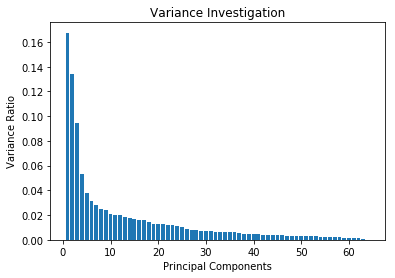

In [39]:
# Investigate the variance accounted for by each principal component.
plt.bar(np.arange(1,65), pca.explained_variance_ratio_)
plt.title("Variance Investigation")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")
plt.show()

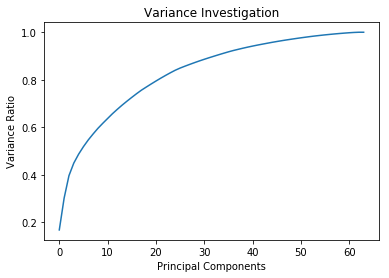

In [31]:
# visualize which number of components account for the most variance
sums = np.cumsum(pca.explained_variance_ratio_)
plt.plot(sums)
plt.title("Variance Investigation")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")
plt.show()

In [91]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=32)
pca_reduction = PCA(n_components = 32)
pca_reduction.fit(azdias_fscaled)
pca_reduction2 = pca_reduction.transform(azdias_fscaled)

pca_reduction2.shape


(774743, 32)

In [62]:
#check the percentage of variance this selection covers
np.sum(pca_reduction.explained_variance_ratio_)

0.89237047424709826

### Discussion 2.2: Perform Dimensionality Reduction

My scaled dataframe had 64 features. When investigating I noticed that about half of that number, 32, seemed to account for 90% of the variance. I was slightly off: .89 vs .90, but still very close. It will make sense to retain these 32 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weight(pca,i):
    weight = pd.DataFrame(pca.components_, columns = list(azdias_fscaled))
    sort_weight = weight.iloc[i].sort_values(ascending = False)
    return sort_weight


In [64]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1 = pca_weight(pca_reduction, 0)
pc1

PLZ8_ANTG3                        0.226151
PLZ8_ANTG4                        0.218232
HH_EINKOMMEN_SCORE                0.203000
CAMEO_INTL_2015_WEALTH            0.202670
ORTSGR_KLS9                       0.197161
EWDICHTE                          0.195130
FINANZ_HAUSBAUER                  0.161376
KBA05_ANTG4                       0.154298
PLZ8_ANTG2                        0.153929
FINANZ_SPARER                     0.150242
ARBEIT                            0.142954
KBA05_ANTG3                       0.136857
ANZ_HAUSHALTE_AKTIV               0.136311
RELAT_AB                          0.135080
SEMIO_PFLICHT                     0.118327
SEMIO_REL                         0.115729
PRAEGENDE_JUGENDJAHRE_DECADE      0.109799
SEMIO_RAT                         0.097500
SEMIO_TRADV                       0.091222
SEMIO_MAT                         0.081402
SEMIO_FAM                         0.079653
FINANZ_UNAUFFAELLIGER             0.079194
SEMIO_KULT                        0.073670
FINANZ_ANLE

In [65]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2 = pca_weight(pca_reduction, 1)
pc2


ALTERSKATEGORIE_GROB              0.257664
SEMIO_ERL                         0.230357
FINANZ_VORSORGER                  0.230239
SEMIO_LUST                        0.180325
RETOURTYP_BK_S                    0.163549
SEMIO_KRIT                        0.118444
FINANZ_HAUSBAUER                  0.118168
SEMIO_KAEM                        0.114701
W_KEIT_KIND_HH                    0.113795
PLZ8_ANTG3                        0.097429
EWDICHTE                          0.095149
ORTSGR_KLS9                       0.093845
PLZ8_ANTG4                        0.092297
ANREDE_KZ                         0.092148
CAMEO_INTL_2015_WEALTH            0.082255
KBA05_ANTG4                       0.072853
SEMIO_DOM                         0.072065
ARBEIT                            0.069250
PLZ8_ANTG2                        0.067215
RELAT_AB                          0.066983
ANZ_HAUSHALTE_AKTIV               0.064125
FINANZ_MINIMALIST                 0.063155
WOHNDAUER_2008                    0.057754
HH_EINKOMME

In [66]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3 = pca_weight(pca_reduction, 2)
pc3


SEMIO_VERT                        0.346050
SEMIO_SOZ                         0.262978
SEMIO_FAM                         0.249353
SEMIO_KULT                        0.233092
FINANZ_MINIMALIST                 0.155436
RETOURTYP_BK_S                    0.109689
FINANZ_VORSORGER                  0.100754
W_KEIT_KIND_HH                    0.085181
ALTERSKATEGORIE_GROB              0.079320
SEMIO_REL                         0.069017
SEMIO_LUST                        0.064239
SEMIO_MAT                         0.055059
ORTSGR_KLS9                       0.049642
EWDICHTE                          0.048987
GREEN_AVANTGARDE                  0.048656
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.048656
PLZ8_ANTG3                        0.048196
PLZ8_ANTG4                        0.047940
ARBEIT                            0.036192
RELAT_AB                          0.033401
PLZ8_ANTG2                        0.032414
WOHNDAUER_2008                    0.032324
CAMEO_INTL_2015_WEALTH            0.030302
KBA05_ANTG4

### Discussion 2.3: Interpret Principal Components

***Principal Component 1***   
Appears to show a positive correlation for urban areas or higher population density vs lower density or non-urban  
**Top 3**  
PLZ8_ANTG3                        0.226151  
-Number of 6-10 family houses in the PLZ8 region    
PLZ8_ANTG4                        0.218232  
-Number of 10+ family houses in the PLZ8 region    
HH_EINKOMMEN_SCORE                0.203000  
-Estimated household net income    
     
**Bottom 3**  
FINANZ_MINIMALIST                -0.221788  
-MINIMALIST: low financial interest  
PLZ8_ANTG1                       -0.225977   
-Number of 1-2 family houses in the microcell  
MOBI_REGIO                       -0.229761  
-Movement patterns  
  
***Principal Component 2***  
Appears to show a positive correlation for age groups and preference for 'experiences' vs more conservative upgringing and mentality  
**Top 3**  
ALTERSKATEGORIE_GROB              0.257664   
-Estimated age based on given name analysis  
SEMIO_ERL                         0.230357  
-ERL: event-oriented  
FINANZ_VORSORGER                  0.230239  
-VORSORGER: be prepared
  
**Bottom 3**    
FINANZ_SPARER                    -0.233265  
-SPARER: money-saver  
PRAEGENDE_JUGENDJAHRE_DECADE     -0.240072    
-Dominating movement of person's youth   
SEMIO_REL                        -0.255386    
-REL: religious  
  
***Principal Component 3***  
Appears to show a positive correlation for some personality traits vs others. The positive appear to be more feminine traits and I would suspect the gender would lean male based on the negative traits.  
**Top 3**  
SEMIO_VERT                        0.346050  
-VERT: dreamful  
SEMIO_SOZ                         0.262978  
-SOZ: socially-minded  
SEMIO_FAM                         0.249353  
-FAM: family-minded 
    
**Bottom 3**  
SEMIO_DOM                        -0.313183  
-DOM: dominant-minded    
SEMIO_KAEM                        -0.336080  
-KAEM: combative attitude  
ANREDE_KZ                        -0.368045  
-Gender  
  
(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

# run k-means clustering on the data and...
# compute the average within-cluster distances.
n_clusters = 15
scores = []
for i in range(1,n_clusters):
    kmeans = KMeans(n_clusters = i, random_state = 0).fit(pca_reduction2)
    scores.append(abs(kmeans.score(pca_reduction2)))  

    
    

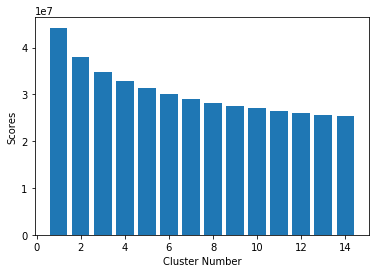

In [98]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
score_array = np.array(scores)
score_array = score_array 
plt.bar(range(1,n_clusters), score_array)
plt.xlabel('Cluster Number')
plt.ylabel('Scores')
plt.show()

In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(pca_reduction2)
predictions = kmeans.predict(pca_reduction2)




### Discussion 3.1: Apply Clustering to General Population

I initially looked at 15 clusters. Based on the image above, the scores start to level off around 10. The instructions state to go no lower than 10, so this seems like a good number to proceed with. 



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [69]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [70]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers)
cleaned_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,50.0,1.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,50.0,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,40.0,0.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,70.0,0.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,50.0,1.0,3.0,4.0


In [81]:
#transformations
cust_imputed = imputer.transform(cleaned_customers)

cust_scaled = scaler.transform(cust_imputed)

cust_scaled = pd.DataFrame(cust_scaled, index = list(cleaned_customers.index), columns = list(cleaned_customers.columns))

cust_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
0,1.180995,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.818216,1.882757,-1.637628,...,-0.953065,1.435587,1.467394,-2.187068,-1.439172,-1.533403,-1.624552,1.882757,-1.571248,0.092492
2,1.180995,0.958422,1.415239,-1.151076,1.133590,-1.247929,0.981043,0.612067,1.882757,-0.315096,...,0.422301,-0.625000,-1.243313,-0.179238,-0.132956,-0.058229,-1.624552,1.882757,-0.224822,0.763676
3,1.180995,-1.043381,1.415239,-1.151076,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.953065,-0.625000,0.563825,-2.187068,-1.003767,-1.533403,-2.307192,-0.531136,-0.898035,0.763676
4,0.198811,-1.043381,-0.036773,-1.151076,0.407498,0.789423,1.698711,-0.818216,-0.531136,1.007436,...,0.422301,-0.625000,-0.339744,-0.179238,-0.132956,-1.533403,-0.259273,-0.531136,0.448391,-1.249876
5,0.198811,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.103075,1.882757,1.007436,...,0.422301,1.435587,1.467394,-0.179238,0.737855,1.416945,-1.624552,1.882757,-0.224822,0.763676


In [82]:
#Apply PCA
cust_pca = pca.transform(cust_scaled)

In [95]:
#Apply clusters
cust_predictions = kmeans.predict(cust_pca)

ValueError: Incorrect number of features. Got 64 features, expected 32

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.